In [1]:
## Bring in needed mods
import pandas as pd,numpy as np, seaborn as sns
from matplotlib import pyplot as plt, rc
%matplotlib inline

In [2]:
## Set parental labels
_xllabelal = 'XL280'+r'$\alpha$'
_xllabel = 'XL280' +r'$\bf{a}$'
_431label = '431'+r'$\mathrm{\alpha}$'

In [3]:
## Set coloring and Background
plt.style.use('tableau-colorblind10')

In [4]:
## set path to file, should in in the words, "curation_baselined.csv'
file_path = '../DATA/PHENOTYPE/GROWTHCURVES/Tecan-ssk1KO_baselined.csv.gz'

In [5]:
## Bring in data
df = pd.read_csv(file_path,index_col=0)

In [6]:
df.columns = [a.capitalize() for a in df.columns.tolist()]

In [7]:
df.Background.unique()

array(['431', 'XL280a', 'none', 'XL280alpha', 'JEC21'], dtype=object)

In [8]:
## Take column names
dfcols = df.columns.tolist()

In [9]:
## Get time start index
timeix = dfcols.index('0s')

In [10]:
## Get time columns
timepts = dfcols[timeix:]
timex = np.array([int(t[:-1])/(60**2) for t in timepts])

In [11]:
## Get info columns
infos = dfcols[:timeix]

In [12]:
## Check baselining
assert df[timepts[:7]].sum(axis=1).sum() == 0

In [13]:
## Write ftn for median filtering
def median_filter(Y,Kernal,padtype=None,recursive=False):
    if Kernal % 2 == 0:
        Kernal = Kernal + 1
    else:
        pass
    window = int((Kernal-1)/2)
    Y = np.array(Y,float)
    assert len(Y[~np.isnan(Y)]) == len(Y)
    if padtype is None:
        rb = np.ones(window)*Y[0]
        re = np.ones(window)*Y[-1]
    elif padtype is 'Zero':
        rb = np.zeros(window)
        re = np.zeros(window)
    elif padtype is 'Ref':
        rb = list(Y[0] - Y[::-1] + Y[0])[-(window+1):-1]
        re = list(Y[-1] - Y[::-1] + Y[-1])[1:(window+1)]
    else:
        rb = np.zeros(window)
        re = np.ones(window)*Y[-1]
    pry = np.concatenate([rb,Y,re])
    if recursive:
        for i in np.arange(window,len(pry)-window):
            pry[i] = np.median(pry[i-window:i+window+1])
        my = pry[window:-window]
    else:
        my = np.array([np.median(pry[i-window:i+window+1]) for i in np.arange(window,len(pry)-window)])
    return my

In [14]:
df[(df.Background=='XL280a')].groupby(['Strain','Study','Compare','Amphb','Temp']).count().T.head()

Strain          4a-6                           4b-2                       \
Study        current                        current                        
Compare    Dec182019       Dec62019       Dec182019       Dec62019         
Amphb          0.000 0.125    0.000 0.125     0.000 0.125    0.000 0.125   
Temp              30    30       30    30        30    30       30    30   
Date               3     9        3     9         3     9        3     9   
Row                3     9        3     9         3     9        3     9   
Column             3     9        3     9         3     9        3     9   
Background         3     9        3     9         3     9        3     9   
Plate              3     9        3     9         3     9        3     9   

Strain          5a-8        ...      XL F                         XL280a  \
Study        current        ...   current                        current   
Compare    Dec182019        ... Dec182019       Dec62019       Dec182019   
Amphb          0.000 0.125  ...     0.000 0.125    0.000 0.125     0.000   
Temp              30    30  ...        30    30       30    30        30   
Date               3     9  ...         3     9        3     9         3   
Row                3     9  ...         3     9        3     9         3   
Column             3     9  ...         3     9        3     9         3   
Background         3     9  ...         3     9        3     9         3   
Plate              3     9  ...         3     9        3     9         3   

Strain                                          
Study                           previous        
Compare          Dec62019       previous        
Amphb      0.125    0.000 0.125    0.000 0.125  
Temp          30       30    30       30    30  
Date           9        3     9        4     4  
Row            9        3     9        4     4  
Column         9        3     9        4     4  
Background     9        3     9        4     4  
Plate          9        3     9        4     4  

[5 rows x 26 columns]

In [15]:
df.Background.unique()

array(['431', 'XL280a', 'none', 'XL280alpha', 'JEC21'], dtype=object)

In [16]:
test = df[(df.Background=='H99') & (df.Amphb==0.125) & (df.Compare.isin(['Dec182019']))].copy()

In [17]:
dx = np.min(np.unique(np.round(np.diff(timex),2)))

In [18]:
test['AUC'] = test[timepts].sum(axis=1)*dx

In [19]:
def curveplot(df,timex,ax,color='k',alpha=0.5,z=1.96,label=None):
    plt.sca(ax)
    
    m = df.mean().values
    std = df.std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(df.shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(df.shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=alpha-0.25)
    plt.plot(timex,m,label=label,alpha=alpha)

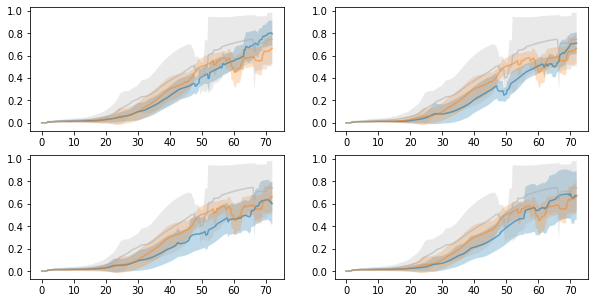

In [20]:
temp = df[(df.Compare=='Dec182019') & (df.Background=='XL280a')]

fig,ax = plt.subplots(2,2,figsize=(10,5))

xl280p = df[(df.Compare=='previous') & 
            (df.Strain=='XL280a') & (df.Amphb==0.125)][timepts]
xl280r = temp[(temp.Strain=='XL280a') & 
            (temp.Amphb==0.125)][timepts]
for i,Strain in enumerate(temp.Strain.unique()[1:-1]):
    az = ax.ravel()[i]
    curveplot(temp[(temp.Strain==Strain) & 
                   (temp.Amphb==0.125)][timepts],timex,az)
    
    curveplot(xl280r,timex,az)
    curveplot(xl280p,timex,az)

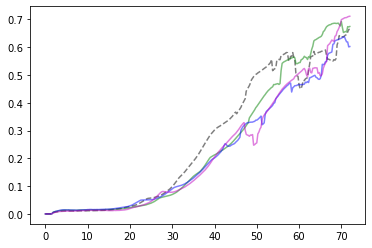

In [21]:
plt.plot(timex,temp[(temp.Strain=='XL280a') & (temp.Study=='current') &
                  (temp.Amphb!=0)][timepts].mean().values,color='k',alpha=0.5,linestyle='--');

plt.plot(timex,temp[(temp.Strain=='5b-1') & (temp.Amphb==0.125)][timepts].mean(),color='g',alpha=0.5);
plt.plot(timex,temp[(temp.Strain=='5a-8') & (temp.Amphb==0.125)][timepts].mean(),color='b',alpha=0.5);
plt.plot(timex,temp[(temp.Strain=='4b-2') & (temp.Amphb==0.125)][timepts].mean(),color='m',alpha=0.5);

In [22]:
## Set kerneal zise to 10 time points (1.5 hrs), around a given pt
ks = 51
## Median filter the data via the awesome ftn I wrote above! 
mdf = df[timepts].T.apply(median_filter,args=[ks]).T

In [23]:
## add info dataframe
mdfi = pd.concat([df[infos],mdf],axis=1)

In [24]:
mdfi.Amphb.unique()

array([0.125, 0.   ])

In [25]:
## Check the parental Strain SS-A837, at 37°C with 0.125 ug/ml Amph. B.
_431ix = mdfi[(mdfi.Background=='431')].index.tolist()

In [26]:
mdfi.T[_431ix].T.Strain.unique()

array(['431', '1a-1', '1a-12', '431 F'], dtype=object)

In [27]:
comdf = mdfi[['Compare','Temp','Amphb']
            ].drop_duplicates().sort_values(['Amphb']
                ).reset_index(drop=True).copy()
comdf

,Compare,Temp,Amphb
0,Dec62019,30,0.000
1,previous,30,0.000
2,Dec182019,30,0.000
3,Dec62019,30,0.125
4,previous,30,0.125
5,Dec182019,30,0.125


In [28]:
mdfi.Background.unique()

array(['431', 'XL280a', 'none', 'XL280alpha', 'JEC21'], dtype=object)

In [29]:
unique_Strains = mdfi.Strain.unique()
unique_Strains

array(['431', 'XL280a', '1a-1', '1a-12', '4a-6', '4b-2', '5a-8', '5b-1',
       '431 F', 'XL F', 'H99', 'CM018', 'ssk1 CM018', 'SSK1 R',
       'XL280alpha', 'JEC21', '7b-14', '7b-16', '8b-9', 'JEC21 F',
       'ssk1 H99'], dtype=object)

In [30]:
mdfi = mdfi.sort_values(['Background','Strain','Compare'])
mdfi.head()

,Date,Row,Column,Strain,Background,Study,Compare,Plate,Temp,Amphb,...,251100s,252000s,252901s,253800s,254700s,255601s,256500s,257400s,258301s,259200s
498,Dec182019,b,4,1a-1,431,current,Dec182019,ssk1KO 2a,30,0.125,...,1.1038,1.1038,1.1038,1.1038,1.1038,1.1038,1.1038,1.1038,1.1038,1.1038
512,Dec182019,c,6,1a-1,431,current,Dec182019,ssk1KO 2a,30,0.125,...,1.1868,1.1868,1.1868,1.1868,1.1868,1.1868,1.1878,1.1878,1.1878,1.1878
525,Dec182019,d,7,1a-1,431,current,Dec182019,ssk1KO 2a,30,0.125,...,1.1854,1.1854,1.1864,1.1864,1.1864,1.1864,1.1864,1.1864,1.1864,1.1864
604,Dec182019,b,4,1a-1,431,current,Dec182019,ssk1KO 2b,30,0.125,...,1.0672,1.0672,1.0672,1.0672,1.0672,1.0672,1.0672,1.0672,1.0672,1.0672
621,Dec182019,c,6,1a-1,431,current,Dec182019,ssk1KO 2b,30,0.125,...,1.0662,1.0662,1.0662,1.0662,1.0662,1.0662,1.0662,1.0662,1.0662,1.0662


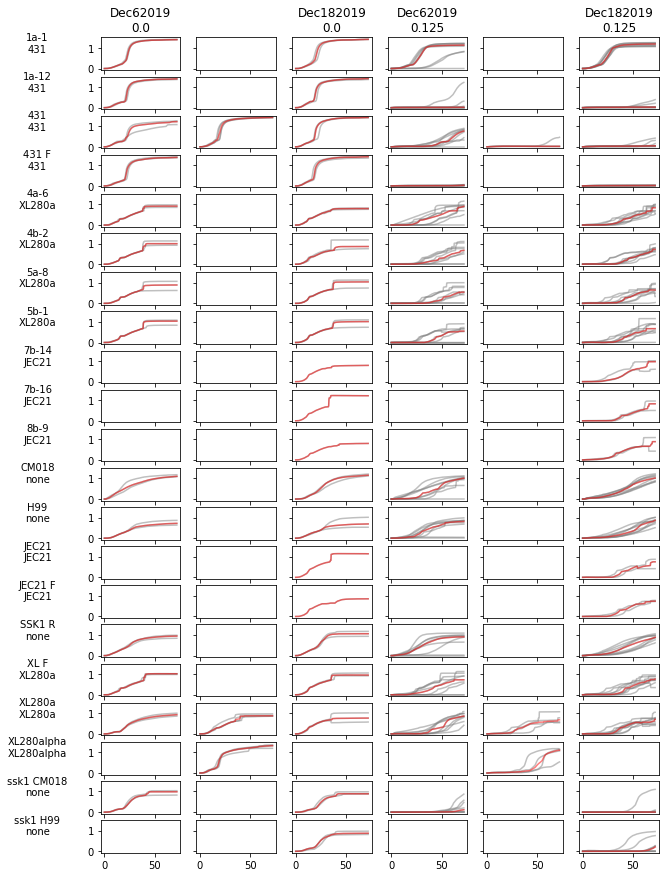

In [31]:
fig,ax = plt.subplots(unique_Strains.shape[0],
                      comdf.shape[0],
                      figsize=(10,15),
                      sharex=True,sharey=True)
c = 0
for i,j in mdfi.groupby('Strain'):
    
    plt.sca(ax[c,0])
    plt.ylabel(i+'\n'+j.Background.unique()[0],
               rotation=0,labelpad=50)
    
    for l,k in j.groupby(['Compare','Amphb']):
        
        z = comdf[(comdf.Compare==k.Compare.unique()[0]) & 
                  (comdf.Amphb==k.Amphb.unique()[0])].index[0]
        plt.sca(ax[c,z])
        plt.title(str(k.Compare.unique()[0])+'\n'+str(k.Amphb.unique()[0] ) if c == 0 else None)
        plt.plot(timex,k[timepts].T,color='grey',alpha=0.5)
        plt.plot(timex,k[timepts].median(axis=0).values,
                 color='r',alpha=0.5)
    c = c+1

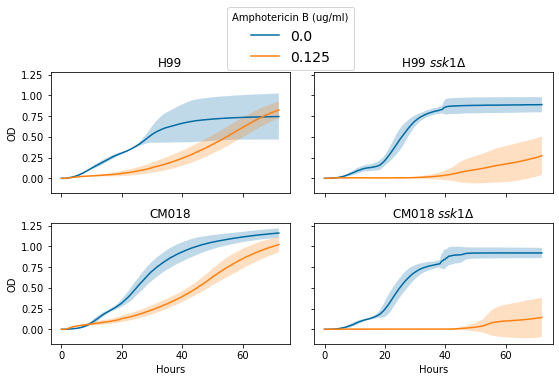

In [32]:
fig, ax = plt.subplots(2,2,figsize=(9,5),sharex=True,sharey=True)
h99 = mdfi[(mdfi.Strain=='H99') & (mdfi.Compare=='Dec182019')]
plt.sca(ax[0,0])
z = 1.96
plt.title('H99')
for i,a in enumerate(sorted(h99.Amphb.unique())):
    
    m = h99[(h99.Amphb==a)][timepts].mean().values
    std = h99[(h99.Amphb==a)][timepts].std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(h99[(h99.Amphb==a)].shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(h99[(h99.Amphb==a)].shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=0.25)
    plt.plot(timex,m);
    
    
plt.ylabel('OD')

plt.sca(ax[0,1])
plt.title('H99 $ssk1$\u0394')
h99k = mdfi[(mdfi.Strain=='ssk1 H99') & (mdfi.Compare=='Dec182019')]
for i,a in enumerate(sorted(h99.Amphb.unique())):
    
    m = h99k[(h99k.Amphb==a)][timepts].mean().values
    std = h99k[(h99k.Amphb==a)][timepts].std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(h99k[(h99k.Amphb==a)].shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(h99k[(h99k.Amphb==a)].shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=0.25)
    plt.plot(timex,m,label=a);
    
    
    
plt.legend(title='Amphotericin B (ug/ml)',fontsize=14,bbox_to_anchor=(.2,1.6));

    

h99 = mdfi[(mdfi.Strain=='CM018') & (mdfi.Compare=='Dec182019')]
plt.sca(ax[1,0])
plt.title('CM018')
for i,a in enumerate(sorted(h99.Amphb.unique())):
    m = h99[(h99.Amphb==a)][timepts].mean().values
    std = h99[(h99.Amphb==a)][timepts].std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(h99[(h99.Amphb==a)].shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(h99[(h99.Amphb==a)].shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=0.25)
    plt.plot(timex,m);
    
    
    
plt.ylabel('OD')
plt.xlabel('Hours')
    
h99k = mdfi[(mdfi.Strain=='ssk1 CM018') & (mdfi.Compare=='Dec182019')]
plt.sca(ax[1,1])
plt.title('CM018 $ssk1$\u0394')
for i,a in enumerate(sorted(h99.Amphb.unique())):
    m = h99k[(h99k.Amphb==a)][timepts].mean().values
    std = h99k[(h99k.Amphb==a)][timepts].std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(h99k[(h99k.Amphb==a)].shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(h99k[(h99k.Amphb==a)].shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=0.25)
    plt.plot(timex,m)

plt.xlabel('Hours')
    
plt.subplots_adjust(wspace=0.1,hspace=0.25)

In [33]:
def r_squared(y,y_approx):
    """Calculates the coefficent of determination"""
    residuals = y - y_approx;
    ss_res = np.sum(residuals**2);
    ss_tot = np.sum((y-np.mean(y))**2);
    return 1.0 - (ss_res / ss_tot)

In [34]:
mdfi.Strain.unique()

array(['1a-1', '1a-12', '431', '431 F', '7b-14', '7b-16', '8b-9', 'JEC21',
       'JEC21 F', '4a-6', '4b-2', '5a-8', '5b-1', 'XL F', 'XL280a',
       'XL280alpha', 'CM018', 'H99', 'SSK1 R', 'ssk1 CM018', 'ssk1 H99'],
      dtype=object)

In [35]:
mytest = mdfi[(mdfi.Strain=='4b-2') & (mdfi.Temp==30) & (mdfi.Amphb==0.125) & (mdfi.Date=='Dec182019')]
mytest.shape

(9, 300)

In [36]:
dt = np.round(np.max(np.diff(timex)),3)

In [37]:
mdfi['AUC'] = mdfi[timepts].sum(axis=1)*dt

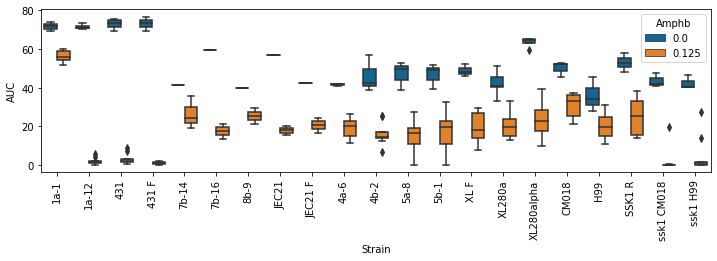

In [38]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
sns.boxplot(x='Strain',y='AUC',hue='Amphb',data=mdfi[(mdfi.Compare!='Dec62019')])
plt.xticks(rotation=90);

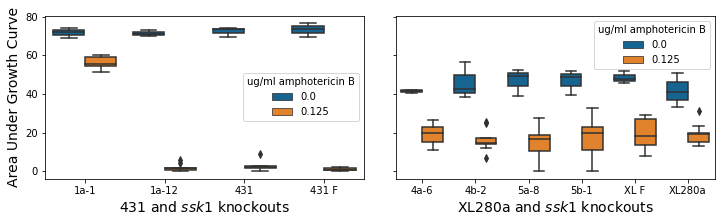

In [39]:
fig,ax=plt.subplots(1,2,figsize=(12,3),sharey=True)
plt.sca(ax[0])
sns.boxplot(x='Strain',y='AUC',hue='Amphb',
            data=mdfi[(mdfi.Background=='431')&
                      (mdfi.Compare=='Dec182019')])
plt.xlabel('431 and $ssk1$ knockouts',fontsize=14)
plt.ylabel('Area Under Growth Curve',fontsize=14)
plt.legend(title='ug/ml amphotericin B')


plt.sca(ax[1])
sns.boxplot(x='Strain',y='AUC',hue='Amphb',
            data=mdfi[(mdfi.Background=='XL280a')&
                      (mdfi.Compare=='Dec182019')])
plt.xlabel('XL280a and $ssk1$ knockouts',fontsize=14)
plt.ylabel(' ')
plt.legend(title='ug/ml amphotericin B')

plt.subplots_adjust(wspace=0.1)
#plt.savefig('../FIGURES/431_XL280_ssk1_knockouts.png',
#            dpi=150,bbox_inches='tight');
#plt.xticks(rotation=90);

In [40]:
xl280=mdfi[(mdfi.Background=='XL280a')& (mdfi.Strain!='XL F') &
                      (mdfi.Compare=='Dec182019')]
_431=mdfi[(mdfi.Background=='431')& (mdfi.Strain!='431 F') &
                      (mdfi.Compare=='Dec182019')]

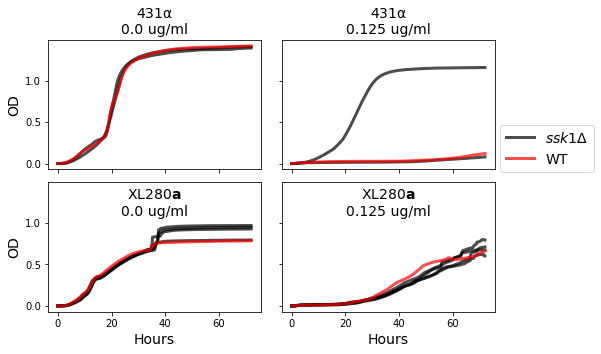

In [41]:
fig,ax = plt.subplots(2,2,figsize=(8,5),sharey=True,sharex=True)
plt.sca(ax[0,0])
plt.plot(timex,_431[(_431.Amphb==0) & 
                    (_431.Strain!='431')
                   ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='k',alpha=0.7,linewidth=3);

plt.plot(timex,_431[(_431.Amphb==0) & 
                    (_431.Strain=='431')
                   ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='r',alpha=0.7,linewidth=3);
plt.ylabel('OD',fontsize=14)
plt.title(_431label + '\n0.0 ug/ml',fontsize=14)

plt.sca(ax[0,1])
plt.plot(timex,_431[(_431.Amphb==0.125) & 
                    (_431.Strain!='431')
                   ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='k',alpha=0.7,linewidth=3);

plt.plot(timex,_431[(_431.Amphb==0.125) & 
                    (_431.Strain=='431')
                   ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='r',alpha=0.7,linewidth=3);
plt.title(_431label + '\n0.125 ug/ml',fontsize=14)


plt.sca(ax[1,0])
plt.plot(timex,xl280[(xl280.Amphb==0) & 
                     (xl280.Strain!='XL280a')
                    ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='k',alpha=0.7,linewidth=3);

plt.plot(timex,xl280[(xl280.Amphb==0) & 
                     (xl280.Strain=='XL280a')
                    ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='r',alpha=0.7,linewidth=3);
plt.xlabel('Hours',fontsize=14)
plt.ylabel('OD',fontsize=14)
plt.title(_xllabel + '\n0.0 ug/ml',y=0.7,fontsize=14)

plt.sca(ax[1,1])
plt.plot(timex,xl280[(xl280.Amphb==0.125)& 
                     (xl280.Strain=='4a-6')
                    ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='k',alpha=0.7,linewidth=3,label='$ssk1$\u0394');

plt.plot(timex,xl280[(xl280.Amphb==0.125)& 
                     ~(xl280.Strain.isin(['XL280a','4a-6']))
                    ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='k',alpha=0.7,linewidth=3);

plt.plot(timex,xl280[(xl280.Amphb==0.125) & 
                     (xl280.Strain=='XL280a')
                    ].groupby(['Strain']).agg(np.mean)[
    timepts].T,color='r',alpha=0.7,linewidth=3,label='WT');
plt.legend(fontsize=14,bbox_to_anchor=(1.5,1.5))
plt.xlabel('Hours',fontsize=14);
plt.title(_xllabel + '\n0.125 ug/ml',y=0.7,fontsize=14)



plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.savefig('../FIGURES/XL280a_431_ssk1_knockouts.png',
#            dpi=300,bbox_inches='tight');

In [42]:
mdfi[(mdfi.Strain=='ssk1 H99')].head()

,Date,Row,Column,Strain,Background,Study,Compare,Plate,Temp,Amphb,...,252000s,252901s,253800s,254700s,255601s,256500s,257400s,258301s,259200s,AUC
547,Dec182019,f,5,ssk1 H99,none,current,Dec182019,ssk1KO 2a,30,0.125,...,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.0016,0.12330
558,Dec182019,g,4,ssk1 H99,none,current,Dec182019,ssk1KO 2a,30,0.125,...,0.2112,0.2162,0.2232,0.2272,0.2312,0.2372,0.2422,0.2502,0.2572,1.60605
565,Dec182019,g,11,ssk1 H99,none,current,Dec182019,ssk1KO 2a,30,0.125,...,0.9510,0.9510,0.9520,0.9540,0.9540,0.9550,0.9560,0.9560,0.9570,27.36800
609,Dec182019,g,4,ssk1 H99,none,current,Dec182019,ssk1KO 2b,30,0.125,...,0.1772,0.1872,0.1952,0.2072,0.2212,0.2352,0.2502,0.2612,0.2752,1.57960
616,Dec182019,f,5,ssk1 H99,none,current,Dec182019,ssk1KO 2b,30,0.125,...,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.15605


In [43]:
_431label = r'$\rm{431}\mathrm{\alpha}$'
_xllabel = r'$\rm{XL280\bf{a}}$'

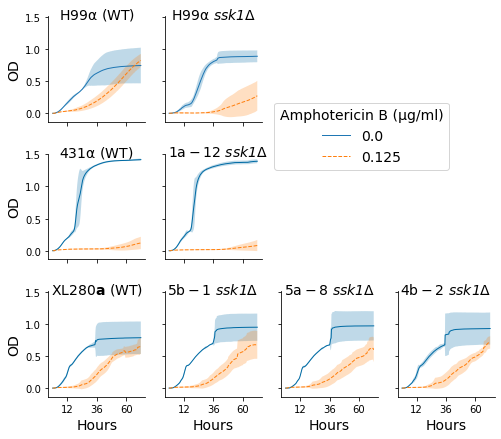

In [44]:
fig,ax = plt.subplots(3,4,figsize=(8,7),sharey=True,sharex=True)
z = 1.96

h99 = mdfi[(mdfi.Strain=='H99') & (mdfi.Compare=='Dec182019')]
plt.sca(ax[0,0])
z = 1.96

h99_title = r'$\rmH99$' + r'$\mathrm{\alpha}$' + ' ' + r'$ \rm(WT)$'
plt.title(h99_title, fontsize=14,y=.92,style='italic')
for i,a in enumerate(sorted(h99.Amphb.unique())):
    
    m = h99[(h99.Amphb==a)][timepts].mean().values
    std = h99[(h99.Amphb==a)][timepts].std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(h99[(h99.Amphb==a)].shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(h99[(h99.Amphb==a)].shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=0.25)
    plt.plot(timex,m,linewidth=1,
             color='tab:blue' if a == 0.0 else 'tab:orange',
             linestyle= '-' if a == 0.0 else '--');
    
    
plt.ylabel('OD',fontsize=14)

h99_ssk_title = r'$\rmH99$' + r'$\mathrm{\alpha}$' + ' ' + 'ssk1' + '$\Delta$'
plt.sca(ax[0,1])
plt.title(h99_ssk_title,fontsize=14,y=.92,style='italic')
h99k = mdfi[(mdfi.Strain=='ssk1 H99') & (mdfi.Compare=='Dec182019')]
for i,a in enumerate(sorted(h99.Amphb.unique())):
    
    m = h99k[(h99k.Amphb==a)][timepts].mean().values
    std = h99k[(h99k.Amphb==a)][timepts].std(ddof=1).values
    
    ci95_hi = m + ((z*std)/np.math.sqrt(h99k[(h99k.Amphb==a)].shape[0]))
    ci95_lo = m - ((z*std)/np.math.sqrt(h99k[(h99k.Amphb==a)].shape[0]))
    plt.fill_between(timex, ci95_hi, ci95_lo, 
             alpha=0.25)
    plt.plot(timex,m,label=a,linewidth=1,
             color='tab:blue' if a == 0.0 else 'tab:orange',
             linestyle= '-' if a == 0.0 else '--');
    
    
legend = plt.legend(title='Amphotericin B (\u03BCg/ml)',fontsize=14,
           bbox_to_anchor=(3,0.25));
plt.setp(legend.get_title(),fontsize=14)


for i, s in enumerate(xl280[(xl280.Strain!='4a-6')].Strain.unique()[::-1]):
    ts = xl280[(xl280.Strain==s)]
    plt.sca(ax[2,i])
    plt.ylabel('OD' if i == 0 else None,fontsize=14)
    plt.xlabel('Hours',fontsize=14)
    plt.xticks([12,36,60])
    plt.title(_xllabel +' ' +  r'$\rm(WT)$' if s == 'XL280a' else r'$\rm%s$'%s + ' ' + 'ssk1' + '$\Delta$',
              fontsize=14,y=.92,style='italic')
    
    for j,k in ts.groupby('Amphb'):
        
        m = k[timepts].mean()
        std = k[timepts].std(ddof=1).values
    
        ci95_hi = m + ((z*std)/np.math.sqrt(k.shape[0]))
        ci95_lo = m - ((z*std)/np.math.sqrt(k.shape[0]))
        
        plt.fill_between(timex, ci95_lo, ci95_hi, alpha=0.25)
        plt.plot(timex,m,
                 linestyle='-' if j == 0.0 else '--',
                 label = '%s (ug/ml)'%j, linewidth=1)
        
        
for i, s in enumerate(_431[(_431.Strain!='1a-1')].Strain.unique()[::-1]):
    ts = _431[(_431.Strain==s)]
    plt.sca(ax[1,i])
    plt.ylabel('OD' if i == 0 else None,fontsize=14)
    #plt.xlabel('Hours' if i == 0 else None,fontsize=14)
    plt.xticks([12,36,60])
    plt.title(_431label + ' ' + r'$\rm(WT)$' if s == '431' else r'$\rm%s$'%s + ' ' + 'ssk1' + '$\Delta$',
             fontsize=14,y=.92,x=.5 if s == '431' else .55,style='italic')
    
    for j,k in ts.groupby('Amphb'):
        m = k[timepts].mean()
        std = k[timepts].std(ddof=1).values
    
        ci95_hi = m + ((z*std)/np.math.sqrt(k.shape[0]))
        ci95_lo = m - ((z*std)/np.math.sqrt(k.shape[0]))
        
        plt.fill_between(timex, ci95_hi, ci95_lo, alpha=0.25)
        plt.plot(timex,m,
                 linestyle='-' if j == 0.0 else '--',
                 label = '%s (ug/ml)'%j,linewidth=1)


qs = [[2,3],[2,3]]#,[2,3]]
for i,q in enumerate([0,1]):#,2]):
    axs = qs[i]
    for p in axs:
        plt.sca(ax[q,p]);plt.axis('off');
    
plt.subplots_adjust(hspace=0.3)

for i in range(3*4):
    
    plt.sca(ax.ravel()[i])
    
    ap = plt.gca()
    [ap.spines[t].set_visible(False) for t in ['top','right']]
    
plt.savefig('../FIGURES/SUPP/PDFs/S16_Fig.pdf',
            dpi=300,bbox_inches='tight');

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [46]:
tempdf = mdfi[(mdfi.Background.isin(['XL280a'])) & (mdfi.Compare=='Dec182019')]

In [47]:
olsm = ols('AUC ~ Amphb*C(Strain)',data=tempdf).fit()

In [48]:
sm.stats.anova_lm(olsm,type=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Strain),5.0,89.129053,17.825811,0.342005,8.853836e-01
Amphb,1.0,10150.339029,10150.339029,194.743742,1.693066e-20
Amphb:C(Strain),5.0,165.365535,33.073107,0.634538,6.741217e-01
Residual,60.0,3127.290951,52.121516,NaN,NaN


In [49]:
olsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AUC   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     18.15
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           3.29e-15
Time:                        16:26:40   Log-Likelihood:                -237.93
No. Observations:                  72   AIC:                             499.9
Df Residuals:                      60   BIC:                             527.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    41.5267      4.168      9.963      0.000      33.189      49.864
C(Strain)[T.4b-2]             4.4993      5.895      0.763      0.448      -7.292      16.290
C(Strain)[T.5a-8]             5.5065      5.895      0.934      0.354      -6.285      17.298
C(Strain)[T.5b-1]             5.1463      5.895      0.873      0.386      -6.645      16.938
C(Strain)[T.XL F]             7.1645      5.895      1.215      0.229      -4.627      18.956
C(Strain)[T.XL280a]           0.1659      5.895      0.028      0.978     -11.625      11.957
Amphb                      -181.6850     38.504     -4.719      0.000    -258.705    -104.665
Amphb:C(Strain)[T.4b-2]     -56.7700     54.453     -1.043      0.301    -165.692      52.152
Amphb:C(Strain)[T.5a-8]     -69.0163     54.453     -1.267      0.210    -177.939      39.906
Amphb:C(Strain)[T.5b-1]     -51.7376     54.453     -0.950      0.346    -160.660      57.185
Amphb:C(Strain)[T.XL F]     -50.5437     54.453     -0.928      0.357    -159.466      58.379
Amphb:C(Strain)[T.XL280a]     1.9995     54.453      0.037      0.971    -106.923     110.922
==============================================================================
Omnibus:                        0.011   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.995   Jarque-Bera (JB):                0.103
Skew:                          -0.028   Prob(JB):                        0.950
Kurtosis:                       2.823   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
## Save dataframe
savepath = '../DATA/PHENOTYPE/GROWTHCURVES/'+file_path.split('/')[-1
            ].split('.csv')[0]+'_median%s.csv.gz'%(ks)

mdfi.to_csv(savepath)